# Laser from longitudinal and transverse profiles

In this tutorial, you will learn to create a Laser from an experimental measurement of the laser spectrum and a 2D image of the transverse intensity profile. We'll start by loading all packages required.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Required for the image processing
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lasy.laser import Laser
from lasy.profiles.combined_profile import CombinedLongitudinalTransverseProfile
from lasy.profiles.longitudinal import LongitudinalProfileFromData
from lasy.profiles.transverse import TransverseProfileFromData
from lasy.profiles.transverse.hermite_gaussian_profile import (
    HermiteGaussianTransverseProfile,
)
from lasy.utils.mode_decomposition import hermite_gauss_decomposition

Next, let's define the physical parameters defining our laser pulse. 

In [2]:
polarization = (1, 0)  # Linearly polarized in the x direction
energy_J = 1  # Pulse energy in Joules
cal = 0.2e-6  # Camera pixel size in meters. Used for calibration

In what follows, we do a few steps to create a LASY profile. Profile is the object used in LASY to describe the properties of the pulse. This profile is then used to create a Laser object, i.e., a regular mesh with the values of the vector potential of the pulse. This mesh can be 3D for a 3D (xyt) geometry, or can consist of a few 2D grids for cylindrical geometry with mode decomposition.

## Reconstruct longitudinal profile

We start from an example dataset obtained with a [Frequency-resolved optical grating (FROG)](https://en.wikipedia.org/wiki/Frequency-resolved_optical_gating) measurement. This provides us with the spectrum and spectral phase.

In [3]:
# Load from online dataset and store in appropriate variables
file_longitudinal = (
    "https://github.com/user-attachments/files/17414077/df_intensity_spectral_v3.csv"
)

exp_frequency = np.loadtxt(file_longitudinal, usecols=0, dtype="float")  # Hz
exp_spectrum = np.loadtxt(file_longitudinal, usecols=1, dtype="float")  # Arbitary units
exp_phase = np.loadtxt(file_longitudinal, usecols=2, dtype="float")  # rad

Now, we initialize a LASY LongitudinalProfile from experimentally measured spectrum. The central wavelength is calculated in this step, and user later on.

In [4]:
longitudinal_data = {
    "datatype": "spectral",
    "axis_is_wavelength": False,
    "axis": exp_frequency,
    "intensity": exp_spectrum,
    "phase": exp_phase,
    "dt": 1e-15,
}

# Create the longitudinal profile. The temporal range is from -200 to +200 femtoseconds
longitudinal_profile = LongitudinalProfileFromData(
    longitudinal_data, lo=-200e-15, hi=200e-15
)

Plot the longitudinal profile data.

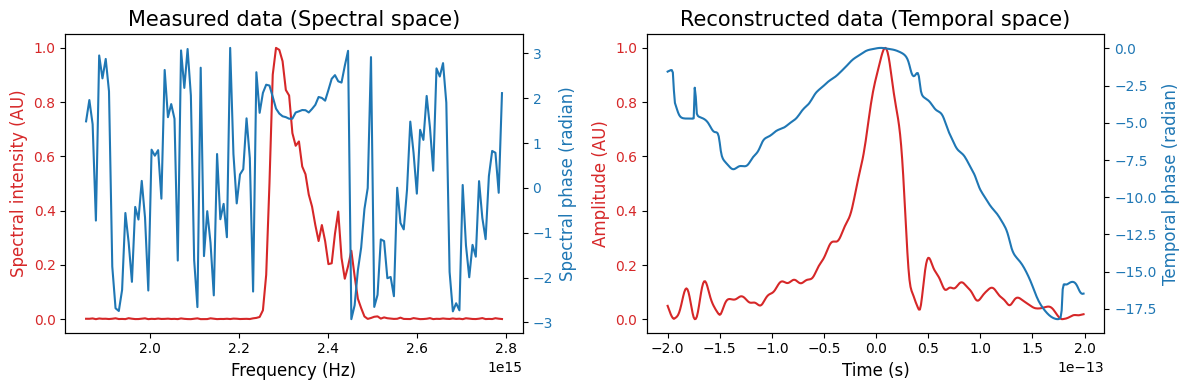

In [5]:
# Plot both the temporal and spectral data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
#fig.suptitle("Overview of the longitudinal profile")

# Spectral data
exp_spectrum /= np.max(exp_spectrum)  # Normalize the spectrum
color = "tab:red"
ax[0].set_xlabel("Frequency (Hz)",fontsize=12)
ax[0].set_ylabel("Spectral intensity (AU)", color=color,fontsize=12)
ax[0].plot(exp_frequency, exp_spectrum, color=color)
ax[0].tick_params(axis="y", labelcolor=color)
ax[0].set_title("Measured data (Spectral space)",fontsize=15)
ax0 = ax[0].twinx()
color = "tab:blue"
ax0.set_ylabel("Spectral phase (radian)", color=color,fontsize=12)
ax0.plot(exp_frequency, exp_phase, color=color)
ax0.tick_params(axis="y", labelcolor=color)


# Temporal data
color = "tab:red"
ax[1].set_xlabel("Time (s)",fontsize=12)
ax[1].set_ylabel("Amplitude (AU)", color=color,fontsize=12)
ax[1].plot(
    longitudinal_profile.time,
    np.sqrt(longitudinal_profile.temporal_intensity),
    color=color,
)
ax[1].tick_params(axis="y", labelcolor=color)
ax[1].set_title("Reconstructed data (Temporal space)",fontsize=15)
ax1 = ax[1].twinx()
color = "tab:blue"
ax1.set_ylabel("Temporal phase (radian)", color=color,fontsize=12)
ax1.plot(longitudinal_profile.time, longitudinal_profile.temporal_phase, color=color)
ax1.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.show()

## Reconstruct transverse profile

For the following reconstruction, the data is provided in the .png image format, which can be read using scikit image package.

In [6]:
# Define the transverse profile of the laser pulse, and perform minor cleaning
file_transverse = "https://user-images.githubusercontent.com/27694869/228038930-d6ab03b1-a726-4b41-a378-5f4a83dc3778.png"
intensity_data = skimage.io.imread(file_transverse)
intensity_scale = np.max(intensity_data)  # Maximum value of the intensity

intensity_data[intensity_data < intensity_scale / 100] = 0

Create a LASY TransverseProfile from our experimental data.

In [7]:
nx, ny = intensity_data.shape
lo = (0, 0)  # Lower bounds in x and y
hi = (ny * cal, nx * cal)  # Upper bounds in x and y

# Create the transverse profile. This also centers the data by default
transverse_profile = TransverseProfileFromData(
    intensity_data, [lo[0], lo[1]], [hi[0], hi[1]]
)

Plot the original transverse profile from the file. The laser occupies a small fraction of the image.

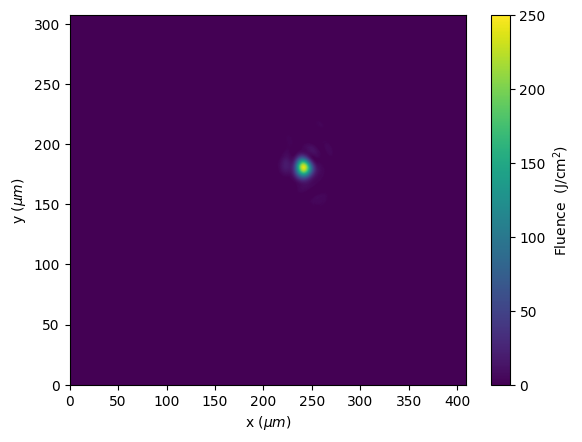

In [8]:
fig, ax = plt.subplots()
cax = ax.imshow(
    intensity_data,
    aspect="auto",
    extent=np.array([lo[0], hi[0], lo[1], hi[1]]) * 1e6,
)
color_bar = fig.colorbar(cax)
color_bar.set_label(r"Fluence  (J/cm$^2$)")
ax.set_xlabel("x ($ \\mu m $)")
ax.set_ylabel("y ($ \\mu m $)")
plt.show()

## Combine longitudinal and transverse profiles

In [15]:
laser_profile_raw = CombinedLongitudinalTransverseProfile(
    wavelength=longitudinal_profile.lambda0,
    pol=polarization,
    laser_energy=energy_J,
    long_profile=longitudinal_profile,
    trans_profile=transverse_profile,
)

## Clean/denoise the profile
LASY functions can be used for denoising/cleaning. Here, the measured profile is decomposed into Hermite-Gauss modes. The cleaning is done by keeping only the first few modes. 
Take a look at the following [example](https://github.com/LASY-org/lasy/blob/13f0e4515493deca36c1375be1d9e83c7e379d42/examples/example_modal_decomposition_data.py).

In [10]:
# Maximum Hermite-Gauss mode index in x and y
n_modes_x = 2
n_modes_y = 2

# Calculate the decomposition and waist of the laser pulse
modeCoeffs, waist = hermite_gauss_decomposition(
    transverse_profile, n_x_max=n_modes_x, n_y_max=n_modes_y, res=cal
)

# Create a num profile, summing over the first few modes
energy_frac = 0
for i, mode_key in enumerate(list(modeCoeffs)):
    tmp_transverse_profile = HermiteGaussianTransverseProfile(
        waist, mode_key[0], mode_key[1]
    )
    energy_frac += modeCoeffs[mode_key] ** 2  # Energy fraction of the mode
    if i == 0:  # First mode (0,0)
        laser_profile_cleaned = modeCoeffs[
            mode_key
        ] * CombinedLongitudinalTransverseProfile(
            longitudinal_profile.lambda0,
            polarization,
            energy_J,
            longitudinal_profile,
            tmp_transverse_profile,
        )
    else:  # All other modes
        laser_profile_cleaned += modeCoeffs[
            mode_key
        ] * CombinedLongitudinalTransverseProfile(
            longitudinal_profile.lambda0,
            polarization,
            energy_J,
            longitudinal_profile,
            tmp_transverse_profile,
        )

# Energy loss due to decomposition
energy_loss = 1 - energy_frac
print(f"Energy loss: {energy_loss * 100:.2f}%")

Estimated w0 = 13.98 microns
Energy loss: 7.28%


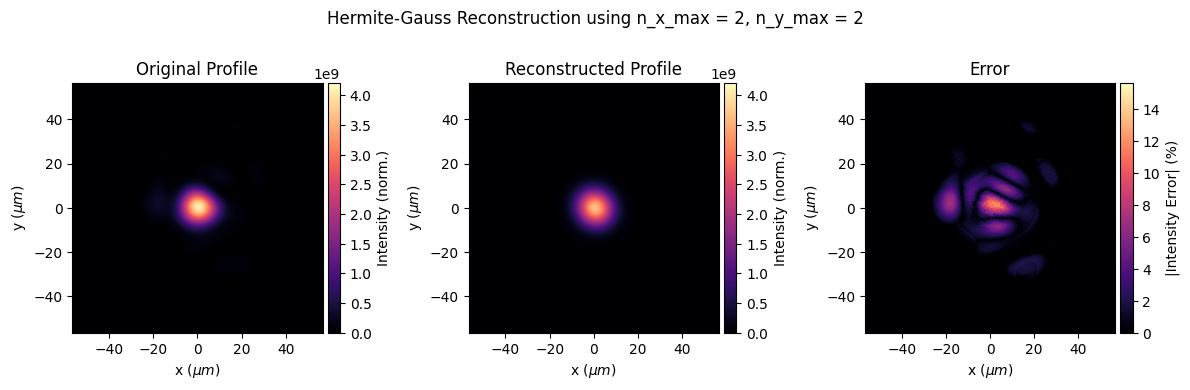

In [11]:
# Plot the original and denoised profiles
# Create a grid for plotting
x = np.linspace(-5 * waist, 5 * waist, 500)
X, Y = np.meshgrid(x, x)

# Determine the figure parameters
fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
fig.suptitle(
    "Hermite-Gauss Reconstruction using n_x_max = %i, n_y_max = %i"
    % (n_modes_x, n_modes_y)
)

# Plot the original profile
pltextent = np.array([np.min(x), np.max(x), np.min(x), np.max(x)]) * 1e6  # in microns
prof1 = np.abs(laser_profile_raw.evaluate(X, Y, 0)) ** 2
divider0 = make_axes_locatable(ax[0])
ax0_cb = divider0.append_axes("right", size="5%", pad=0.05)
pl0 = ax[0].imshow(prof1, cmap="magma", extent=pltextent, vmin=0, vmax=np.max(prof1))
cbar0 = fig.colorbar(pl0, cax=ax0_cb)
cbar0.set_label("Intensity (norm.)")
ax[0].set_xlabel("x ($ \\mu m $)")
ax[0].set_ylabel("y ($ \\mu m $)")
ax[0].set_title("Original Profile")

# Plot the reconstructed profile
prof2 = np.abs(laser_profile_cleaned.evaluate(X, Y, 0)) ** 2
divider1 = make_axes_locatable(ax[1])
ax1_cb = divider1.append_axes("right", size="5%", pad=0.05)
pl1 = ax[1].imshow(prof2, cmap="magma", extent=pltextent, vmin=0, vmax=np.max(prof1))
cbar1 = fig.colorbar(pl1, cax=ax1_cb)
cbar1.set_label("Intensity (norm.)")
ax[1].set_xlabel("x ($ \\mu m $)")
ax[1].set_ylabel("y ($ \\mu m $)")
ax[1].set_title("Reconstructed Profile")

# Plot the error
prof3 = (prof1 - prof2) / np.max(prof1)  # Normalized error
divider2 = make_axes_locatable(ax[2])
ax2_cb = divider2.append_axes("right", size="5%", pad=0.05)
pl2 = ax[2].imshow(100 * np.abs(prof3), cmap="magma", extent=pltextent)
cbar2 = fig.colorbar(pl2, cax=ax2_cb)
cbar2.set_label("|Intensity Error| (%)")
ax[2].set_xlabel("x ($ \\mu m $)")
ax[2].set_ylabel("y ($ \\mu m $)")
ax[2].set_title("Error")

plt.show()

## Create a laser

Now the hard part is done! From the cleaned profile, we create a LASY Laser object (3D cartesian or cylindrical geometry) and write to a file compliant with the openPMD standard.

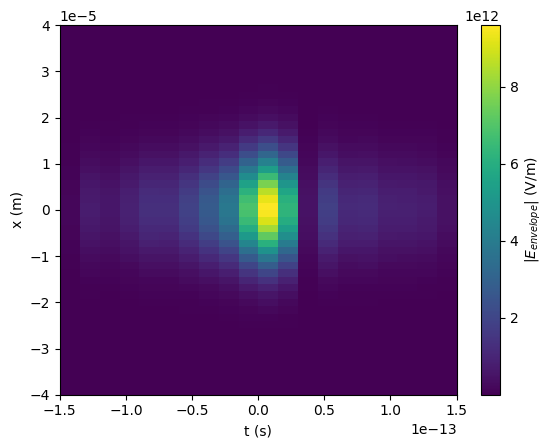

In [12]:
# First, 3D geometry
dimensions = "xyt"  # Use 3D geometry
lo = (-40e-6, -20e-6, -150e-15)  # Lower bounds of the simulation box
hi = (40e-6, 20e-6, 150e-15)  # Upper bounds of the simulation box
num_points = (
    50,
    50,
    20,
)  # Number of points in each dimension. Use (300, 300, 200) for production.

# Constructing the object using 3D geometry might take a while to run depending on the hardware used.
laser_xyt = Laser(dimensions, lo, hi, num_points, laser_profile_cleaned)  # Laser
laser_xyt.normalize(energy_J * energy_frac)  # Normalize the laser energy
laser_xyt.show()

# Save the laser object to a file
laser_xyt.write_to_file("Laser_xyt_denoised", "h5", save_as_vector_potential=True)

  0%|          | 00:00<? [?it/s]

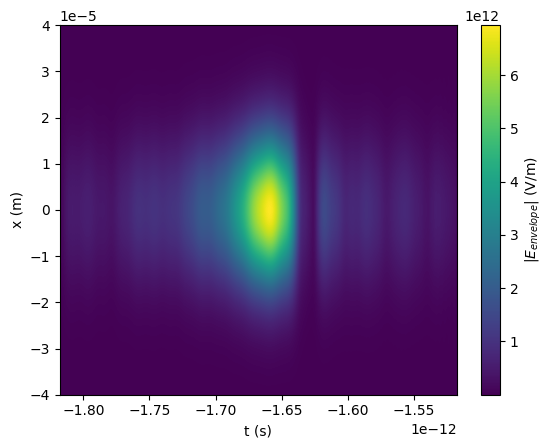

In [13]:
# Then, cylindrical geometry. Here, we also propagate the pulse backwards by 0.5 mm.
dimensions = "rt"  # Use cylindrical geometry
lo = (0, -150e-15)
hi = (40e-6, 150e-15)
num_points = (500, 400)

laser = Laser(dimensions, lo, hi, num_points, laser_profile_cleaned)
laser.normalize(energy_J * energy_frac)
laser.propagate(-0.5e-3)  # Propagate the laser pulse backwards
laser.show()

# Save the laser object to a file
laser.write_to_file("Laser_rt_propagated", "h5", save_as_vector_potential=True)